# Assignment 2.4: Comparing Biological Sequences

# Learning outcomes

- Familiarity with comparing biological sequences under edit distance
- Understanding Dynamic Programming algorithms
- Familiarity with the main idea of calling variants from read alignments, and its challenges
- An understanding that non-trivial algorithms are required for great practical results (not always, but often)

# Contents
### 1. Basics on Dynamic Programming
    1.1 To store or not to store partial answers
    1.2 Longest path in a DAG
    1.3 OPTIONAL: Gap filling as path of given length

### 2. Aligning sequences under edit distance
    2.1 Computing the distance
    2.2 Retrieving the optimal alignment paths
    2.3 Edit distance computation as shortest path problem
    2.4 From alignment paths to sequence alignments

### 3. Variant calling

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 0</strong></h3>

At the end of the assignment, write here how many hours it took to complete it (approximately). Write also general feedback about the assignment. What was difficult, what was easy, what was interesting, what was not, what other tasks / topics you would have liked to have in it?

#### Hours used for the tasks

Somethinkg like 7 hours.

---

#### My backgroung

Mathematics with computer science minor.

---

# 1. Basics on Dynamic Programming

## 1.1. To store or not to store partial answers

Recall that the Fibonacci numbers are a sequence of numbers, where each number $F_i$ is obtained by summing up the two previous numbers $F_{i-1}$ and $F_{i-2}$. The only exceptions are $F_0 = 0$, and $F_1 = 1$. These two values are also called *base cases* of the recurrence $F_i = F_{i-1} + F_{i-2}$.

Consider the following computation of $F_N$, for `N=36`.

In [2]:
from time import time

N = 36

start_time = time()
F = dict()
for i in range(0,N+1):
    if i <= 1:
        F[i] = i
    else:
        F[i] = F[i-1] + F[i-2]

print(F[N])
end_time = time()

print(f'Computation took {round(end_time - start_time, 2): .2f} sec')

14930352
Computation took  0.00 sec


Consider now the following computation of $F_n$, for `n=36` (wait a few seconds for the code to finish running).

In [8]:
def F(i):
    if i < 2: return i
    return F(i-1) + F(i-2)

start_time = time()
print(F(N))
end_time = time()

print(f'Computation took {round(end_time - start_time, 2): .2f} sec')

14930352
Computation took  3.19 sec


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 1</strong></h3>

Explain why the two algorithms above have so different running times, even if they compute the same value, with the same recurrence.

---
#### For loop vs. recursion

The main reason for the time difference is the fact that in the recusrive function the same F(n) values are calculated multiple times. As the function calls itself, on each "layer" it will have to get call the function until it reaches to F(1) or F(0) for both terms in the return sum. Te number of times the function is call increases exponentially, hence for large N the function takes a long time (it has time complexity of O(2^2), in fact).

The for loop on the other hand calculates each F(n) value only once, and is therefore quicker (with time complexity O(n)).

---

## 1.2 Longest path in a DAG

Recall the problem of finding a longest path in a directed acyclic graph, from a node `s` to a node `t`. We already solved this problem in the previous assignment, with a reduction to a min-cost flow problem. In this section we will devise a DP algorithm for it.

Let's read the same graph that we used in the previous assignment, and let's use our visualization function `graph2dot` from the previous assignment.

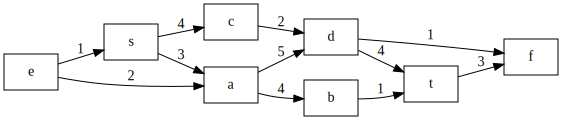

In [9]:
import networkx as nx
from graphviz import Digraph

def graph2dot(nxDigraph, edgeLabels=None):
    dot = Digraph()
    dot.graph_attr['rankdir'] = 'LR' # Display the graph in landscape mode
    dot.node_attr['shape'] = 'rectangle' # Rectangle nodes

    for (u,v) in nxDigraph.edges():
            if edgeLabels is None:
                dot.edge(str(u), str(v)) 
            else:
                dot.edge(str(u), str(v), label=str(nxDigraph[u][v][edgeLabels]))
         
    return dot

fg = open("data/graph1.edgelist", "rb")
G = nx.read_edgelist(fg, create_using=nx.DiGraph)
fg.close()

graph_dot = graph2dot(G, edgeLabels = 'weight')
graph_dot

Let's denote by `L[v]` the *length* of the longest path from node `s` to node `v`. If you give it some thought, you'll realize that we can compute `L[v]` from the `L` values of the in-neighbors of `v` (i.e., of the nodes with edges in-coming to `v`). If we process the nodes of the directed acyclic graph in a topological order (i.e. so that edges go "from left to right"; acyclic graphs always have such an order), then such `L` values of the in-neighbors of `v` are already computed when processing `v`.

The recurrence formula to compute `L[v]` is:
$$ L[v] = \max_{u \in N^-(v)} weight(u,v) + L[u], $$
where $N^-(v)$ denotes the set of in-neighbors of $v$.

The following code implements this DP algorithm.

In [10]:
bigNumber = 1 << 32

def computeLongestPath(G, s, t):
    L = dict()
    bestInNeighbor = dict()
    
    for v in nx.topological_sort(G):
        if v == s:
            L[v] = 0
        else:
            L[v] = -bigNumber
            for u in G.predecessors(v):
                if L[u] != -bigNumber:
                    longestLength = max(L[v], G[u][v]['weight'] + L[u])
                    if longestLength > L[v]:
                        L[v] = longestLength 
                        bestInNeighbor[v] = u
           
    # If no s-t path exists
    if L[t] == -bigNumber:
        return None, None
    
    # Recovering the longest path
    reverse_path = [t]
    while reverse_path[-1] != s:
        reverse_path.append(bestInNeighbor[reverse_path[-1]])
        
    return L[t], list(reversed(reverse_path))

longestLength, longestPath = computeLongestPath(G,'s','t')

print(f'longestLength: {longestLength}')
print(f'longestPath: {longestPath}')

longestLength: 12
longestPath: ['s', 'a', 'd', 't']


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 2</strong></h3>

Given the pseudocode above, explain:
- What are the *base cases* of the recurrence?
- Why all `L[v]` values are initialized to `-bigNumber`?
- Why the check `L[t] == -bigNumber` indicates that no path from `s` to `t` exists?
- How is the longest path from `s` to `t` retrieved?

---
#### computeLongestPath

Base case is the longest path to the source node (L[s]) which is set to zero.

The L[v] is initialized as -bigNumber so that in they will be smaller than any other value, when compared to the actual calculated possible longest path candidates.

If the L[t] == -bigNumber check true, we know that none of the precessors of node t does not have a longest path to it (because they have been initialized as -bignumber and never has the condition L[u] != -bigNumber been fulfilled for them), hence there cannot be any path.

The longest path from s to t is retrieved same way as in previous exercises: Build the reverserd path by initializing with t and then getting the in neighbor of the last node in the list until node s has been added. Then reverse the list and return.


---

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 3</strong></h3>

In the box below, copy the code from above, and modify it to compute a **shortest** (min. weight) path from `s` to `t`. Verify that that the path you obtain is indeed shortest in the example graph visualized above.

In [11]:
def computeShortestPath(G,s,t):
    S = dict()
    bestInNeighbor = dict()
    
    for v in nx.topological_sort(G):
        if v == s:
            S[v] = 0
        else:
            S[v] = bigNumber
            for u in G.predecessors(v):
                if S[u] != bigNumber:
                    shortestLength = min(S[v], G[u][v]['weight'] + S[u])
                    if shortestLength < S[v]:
                        S[v] = shortestLength 
                        bestInNeighbor[v] = u
           
    # If no s-t path exists
    if S[t] == bigNumber:
        return None, None
    
    # Recovering the longest path
    reverse_path = [t]
    while reverse_path[-1] != s:
        reverse_path.append(bestInNeighbor[reverse_path[-1]])
        
    return S[t], list(reversed(reverse_path))
    

shortestLength, shortestPath = computeShortestPath(G,'s','t')

print(f'shortestLength: {shortestLength}')
print(f'shortestPath: {shortestPath}')

shortestLength: 8
shortestPath: ['s', 'a', 'b', 't']


## 1.3 OPTIONAL: Gap filling as path of given length

This section complements section **4. Gap filling** from the Genome Assembly notebook. You don't need to have solved that one, if you want to do this section. However, reading the explanations therein it will give the proper background for this section.

Let's start with some helper functions taken directly from the Genome Assembly notebook.

In [14]:
def merge_strings(s, kmer):
    return s + kmer[-1]

def convert_path_to_string(path, k):
    string = str()
    
    for kmer in path[1:-k]:
        string = merge_strings(string, kmer)
        
    return string

def align(genome, unitigs):
    notFound = 0 # This will store the number of unitigs not found in genome

    for unitig in unitigs:
        pos = genome.find(unitig)
        if pos == -1:
            notFound += 1
    
    return notFound

def get_genome(filePath):
    genome = str()
    
    fastaFile = open(filePath, 'r') 
    
    fastaFile.readline() # Read header line
    fastaLines = fastaFile.readlines()
    fastaFile.close()

    for line in fastaLines:
        genome += line.strip().upper()
    
    return genome

def get_scaffold(filePath):
    string = str()
    
    fastaFile = open(filePath, 'r') 
    fastaFile.readline() # Read header line
    fastaLines = fastaFile.readlines() 
    fastaFile.close()
    
    for line in fastaLines:
        string += line.strip().upper()
    
    pos_firstN = string.find('N')
    pos_lastN = string.rfind('N')
    firstContig = string[:pos_firstN]
    lastContig = string[pos_lastN + 1:]
    gap_length = pos_lastN - pos_firstN + 1
    
    return firstContig, lastContig, gap_length

We now implement the DP algorithm, which we have seen in the group work at the end of the Genome Assembly lecture, finding an `s`-`t` path of a given length. Since the de Bruijn graph has length of each edge equal to $1$, we simplify that DP algorithm. The function `computePathOfLength(G, s, t, d)` is given the directed graph `G` and computes a path from `s` to `t` of a given length `d` (i.e. since each edge has length 1 in the de Bruijn graph, `d` will also equal the number of edges of the path).

In [15]:
def computePathOfLength(G, s, t, d):
    # Returns a path in G from node s to node t of length d
    A = {(s,0)} # A is a set
    for i in range(1,d+1):
        if i % 50 == 0 or i == d: print(f'Processing length {i}...')
        for v in G.nodes():
            for u in G.predecessors(v):
                if (u,i-1) in A:
                    A.add((v,i))
                    break
    
    # If no path is found
    if (t,d) not in A:
        return None
    
    # Recovering the path of length d
    reverse_path = [(t,d)]
    while reverse_path[-1] != (s,0):
        v, l = reverse_path[-1]
        for u in G.predecessors(v):
            if (u,l-1) in A:
                reverse_path.append((u, l-1))
                break
        
    return list(reversed([v[0] for v in reverse_path]))

<h3 style='background:yellow;padding:10px;color:black'><strong>OPTIONAL TASK</strong></h3>

Explain the DP algorithm above.

---
#### computePathOfLength

First the set A is intitalized with the (source node, length) = (s, 0) pair. Then lengths (i) from 1 to d are looped over (and every 50th a update is printed). Fore every node v its predecessors are looped over and if the set A contains a pair (predecessor node, current length minus one) = (u, i-1), then the pair (current node, current legth) = (v, i) is also added in the set A. The set does also store each pair once, even if it's added multiple times.

After handling all lengths until d, it is checked if the d-length path exists to the sink node t. In case it does, the path is constructed very similarly as we have seen in the previous algothms: first building the reversed path list by utilizing the set A and then reversing the reversed list.

---

For convenience, let's consider the de Bruijn graph from the Genome Assembly notebook, which is here stored as file `data/dbGraph.edgelist`. We load this into `dbGraph`. We set `k=15`, since this was the $k$-mer value used to construct that graph.

We then load the scaffold that we need to fill from `data/scaffolds.fasta`, compute the $k$-mer from which to start looking for a filling path, and the $k$-mer where this filling path should end.

Finally, we compute a path in `dbGraph` from `source_kmer` to `target_kmer` of length `gap_length + k`. If we do get such a path, then we fill the scaffold with it, and check that the filled scaffold does appear in the reference genome.

In [16]:
fg = open("data/dbGraph.edgelist", "rb")
dbGraph = nx.read_edgelist(fg, create_using=nx.DiGraph)
fg.close()

k = 15 # order ot the de Bruijn graph

firstContig, lastContig, gap_length = get_scaffold('data/scaffolds.fasta')
path_length = gap_length + k # i.e. the numbner of *edges* of the graph
print(f'We need to fill a gap of length: {gap_length}')

source_kmer = firstContig[-k:]
target_kmer = lastContig[:k]
print(f'Finding a path from source kmer: {source_kmer} to target kmer: {target_kmer}, of length {path_length}...')

solutionPath = computePathOfLength(dbGraph, source_kmer, target_kmer, gap_length + k)

if solutionPath is not None:
    gapString = convert_path_to_string(solutionPath, k)
    print(f'Found a path of length (number of edges): {path_length}, corresponding to a gap filling string of length {gapString}')
    print(f'This path is: {gapString}')

    # Checking that the filled scaffold indeed occurs in the genome
    filledScaffold = firstContig + gapString + lastContig
    trueGenome = get_genome('data/genome.fasta')
    print(f'Filled scaffold aligns to genome: {align(filledScaffold, trueGenome) == 0}')

We need to fill a gap of length: 624
Finding a path from source kmer: TGATGAAGATTAAGA to target kmer: GACGGCCCAAAAATT, of length 639...
Processing length 50...
Processing length 100...
Processing length 150...
Processing length 200...
Processing length 250...
Processing length 300...
Processing length 350...
Processing length 400...
Processing length 450...
Processing length 500...
Processing length 550...
Processing length 600...
Processing length 639...
Found a path of length (number of edges): 639, corresponding to a gap filling string of length AAAAGACAGTCTTGTGATTGTCACTAATCTTCATCTCAAAACATATTATTTTACCAGAAGCTACTATAGCCTACCTCCTTGACACATAGCAAACCTTACTCATGTTGATAATTGTTTGCCTGCTATTTACATATTTACTAACTTACAAAATTATCTTGGGGATTTCTCTGAACATATAATCAGAATTGGCATTTAAAACACAAGTTAGTCCTAATGGACTCATTTCATGAGAGAGGGCGTAGCAGAACTATTCGACAGAGTGCAAGAGATGGGCCGAGTCATCAAGTAAGAACAAGATCATCCTCCAGAGACAGCCACCGCAGCGAATATCATACACCTAGGAGCTCTTCCCAAGTTCGAGTCCCGACTGTGTTTCATCGGAAGCGTACTGATTCTTTGACAGTTCCACCAGCACCAAAGGACATATGTCCTACCTTAAGGAAAG

# 2. Aligning sequences under edit distance

In this section we will implement the dynamic programming algorithm for aligning sequences under the minimum number of edits.

## 2.1 Computing the distance

Let us start by just computing the distance between two strings. We will use the same two strings as in the lecture, so that you can double-check that the distance matrix and edit distance value you obtain are the right ones. 

We use the dynamic programming table `D`, such that `D[i][j]` gives the edit distance between `A[1...i]` and `B[1...j]`. (Since the characters of Python strings are indexed from 0, instead of 1 as in the lecture, we will apply a small trick in the code below, as you will see.) The recursive decomposition of `D[i][j]` is (make sure the math formula is properly rendered):

$$D[i][j]= \min
\begin{cases}
D[i-1][j-1], & \text{ if } B[j] = A[i]\\
D[i-1][j-1] + 1, & \text{ if } B[j] \neq A[i]\\
D[i][j-1] + 1,\\
D[i-1][j] + 1.
\end{cases}$$

The follwing code fragment performs the initializations for computing the table `D`.

In [25]:
import pandas
from IPython.display import display

# Since the characters of a Python string are indexed from 0,
# we add a dummy character * at the beginning of each string.
# In this way, A[1] = 'T', A[2] = 'U', A[3] = 'K', ...
A = '*TUKHOLMA'
B = '*STOCKHOLM'
print(A[1],A[2],A[3])
# Notice that len(A) = 9, that is 1 (len('*')) + 8 (len('TUKHOLMA'))
print(f'len(A) = {len(A)}')

# We initialize with 0 entries a matrix of 
# len(A) rows, indexed 0..len(A)-1
# and len(B) columns, 0..len(B)-1
D = [[0 for j in range(len(B))] for i in range(len(A))]

def initialize_distance_matrix(A, B, D):
    # We do the initializations needed for edit distance computation
    for i in range(len(A)):
        D[i][0] = i
    for j in range(len(B)):
        D[0][j] = j

def show(A,B,D):
    # We display the matrix in a nice tabular format using Python package pandas
    row_labels = [A[i] for i in range(len(A))]
    col_labels = [B[j] for j in range(len(B))]
    display(pandas.DataFrame(data=D, index=row_labels, columns=col_labels))
        
initialize_distance_matrix(A,B,D)
show(A,B,D)

T U K
len(A) = 9


,*,S,T,O,C,K,H,O,L,M
*,0,1,2,3,4,5,6,7,8,9
T,1,0,0,0,0,0,0,0,0,0
U,2,0,0,0,0,0,0,0,0,0
K,3,0,0,0,0,0,0,0,0,0
H,4,0,0,0,0,0,0,0,0,0
O,5,0,0,0,0,0,0,0,0,0
L,6,0,0,0,0,0,0,0,0,0
M,7,0,0,0,0,0,0,0,0,0
A,8,0,0,0,0,0,0,0,0,0


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 4</strong></h3>

Fill in the missing code fragment below, such that the function `compute_distance_matrix` computes the edit distance matrix `D` (using the recurrence shown above and in the lecture).

Double-check that the matrix you obtain is the same as the one from the lecture.

In [26]:
def compute_distance_matrix(A,B,D):
    for i in range(1, len(A)): # for every row, i.e. position in A
        for j in range(1, len(B)): # for every column, i.e. position in B
            if A[i] == B[j]:
                diagonal = D[i-1][j-1]
            else:
                diagonal = D[i-1][j-1] + 1
            left = D[i][j-1] + 1
            right = D[i-1][j] + 1
            D[i][j] = min(diagonal, left, right)            
        
compute_distance_matrix(A,B,D)
show(A,B,D)

,*,S,T,O,C,K,H,O,L,M
*,0,1,2,3,4,5,6,7,8,9
T,1,1,1,2,3,4,5,6,7,8
U,2,2,2,2,3,4,5,6,7,8
K,3,3,3,3,3,3,4,5,6,7
H,4,4,4,4,4,4,3,4,5,6
O,5,5,5,4,5,5,4,3,4,5
L,6,6,6,5,5,6,5,4,3,4
M,7,7,7,6,6,6,6,5,4,3
A,8,8,8,7,7,7,7,6,5,4


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 5</strong></h3>

Retrieve the edit distance of `A` and `B` from the table `D` and print it.

In [29]:
edit_dist = D[-1][-1]
print(f'The edit distance is {edit_dist}')


The edit distance is 4


## 2.2 Retrieving the optimal alignment paths

Once we have computed the distance matrix `D` and the edit distance, we can trace back the optimal alignments of `A` and `B`, as explained at the lecture.

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 6</strong></h3>

Recall that at the lecture we traced back two paths in the matrix `D` corresponding to two optimal alignments (i.e. with the same edit distance $4$) of the two strings. The following function `traceback_all_solutions` implements that method.

Explain in your own words how the function `traceback_all_solutions` below works. Are the two paths it finds the same as the two paths from the lecture?

In [33]:
def traceback_all_solutions(A, B, D, all_alignment_paths, i, j, partial_alignment_path = list()):
    partial_alignment_path.append((i, j))
    
    if i == 0 and D[i][j] == 0:
        all_alignment_paths.append(list(reversed(partial_alignment_path)))
    else:
        if i > 0 and D[i][j] == D[i-1][j] + 1:
            traceback_all_solutions(A, B, D, all_alignment_paths, i-1, j, partial_alignment_path)

        if j > 0 and D[i][j] == D[i][j-1] + 1:
            traceback_all_solutions(A, B, D, all_alignment_paths, i, j-1, partial_alignment_path)
            
        if i > 0 and j > 0:
            if A[i] == B[j]:
                traceback_all_solutions(A, B, D, all_alignment_paths, i-1, j-1, partial_alignment_path)
            elif D[i][j] == D[i-1][j-1] + 1:
                traceback_all_solutions(A, B, D, all_alignment_paths, i-1, j-1, partial_alignment_path)
    
    partial_alignment_path.pop()
    
    
all_alignment_paths_D = list()
traceback_all_solutions(A, B, D, all_alignment_paths_D, len(A)-1, len(B)-1)

for alignment_path in all_alignment_paths_D:
    print(alignment_path)

[(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)]
[(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)]


---
#### traceback_all_solutions

We have a recursive function, that carries over all the variables to the next "layer" as parameters. If the first cell (0, 0) is reach the alignment_path_list is reversed and returned. Otherwise (when there is still cells to trace back to), the four cases, from which we could have ended up in the current cell, are tested:

1. If D[i][j] == D[i-1][j] + 1, the cell one left is part of the solution
2. If D[i][j] == D[i][j-1] + 1, the cell one up is part of the solution
3. If A[i] == B[j] or 4. D[i][j] == D[i-1][j-1] + 1, the cell diagonally up and left is part of the solution

"On the bottom" of each recursion, the latest partial alignment path is removed from the list to keep it clean for building the actual solution path.

---

Let's now use the `graphviz` package to visualize the matrix `D` differently. This will allow us to also draw the alignment paths inside it. We will use the function `matrixpaths2dot` below, that works similarly as `graphpaths2dot` from the previous assignment.

In [34]:
from graphviz import Digraph
import itertools

def matrixpaths2dot(A, B, D, alignment_paths):
    colors = ['red','blue','green','purple','brown','orange','yellow']

    dot = Digraph()
    dot.node_attr['shape'] = 'rectangle' # Rectangle nodes
    
    # Getting the nodes in all alignment paths
    nodes_in_alignment_paths = set(itertools.chain.from_iterable(alignment_paths))
    
    # Drawing the header
    for j in range(len(B)):
        row = Digraph('row-1')
        row.attr(rank='same')
        row.node(str((-1, j)), label=B[j], fillcolor='yellow', style='filled')
        dot.subgraph(row)
    
    # Drawing the table
    for i in range(len(A)): # for every row of D
        row = Digraph(f'row{i}')
        row.attr(rank='same')
        row.node(str((i, -1)), label=A[i], fillcolor='yellow', style='filled')
        for j in range(len(B)): # for every column of D
            if (i,j) in nodes_in_alignment_paths:
                row.node(str((i, j)), label=str(D[i][j]), fillcolor='green', style='filled')
            else:
                row.node(str((i, j)), label=str(D[i][j]))
            dot.edge(str((i, j-1)), str((i, j)))
            dot.edge(str((i-1, j)), str((i, j)))
            if i > 0 and j > 0:
                dot.edge(str((i-1, j-1)),str((i, j)))
        dot.subgraph(row)
         
    # Drawing the alignment paths
    for index, path in enumerate(alignment_paths):
        pathColor = colors[index % len(colors)]
        dot.attr('edge', color=pathColor, penwidth='2.0', weight=str(0.1))
                    
        for i in range(len(path)-1):
            dot.edge(str(path[i]), str(path[i+1]))
            
    return dot

Now, we can visualize the matrix, and `all_alignment_paths` that we computed above.

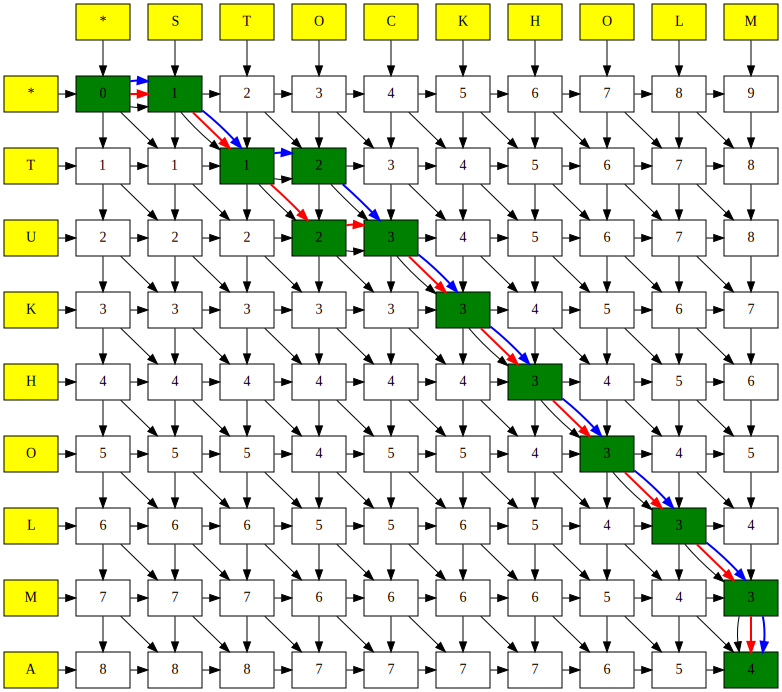

In [35]:
G_dot = matrixpaths2dot(A, B, D, all_alignment_paths_D)
G_dot

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 7</strong></h3>

Now it's your turn to use the functions created above for the following two strings: `ATTCGA` and `ATCAG`. Complete the code fragment below so that you:
- Compute the distance matrix of the strings `A2` and `B2`.
- Print their edit distance.
- Traceback all alignment paths (corresponding to an alignment of minimum edit distance) and print their number.
- Visualize the matrix and all alignment paths using the function `matrixpaths2dot`.

Edit distance between ATTCGA and ATCAG is 3
Found 7 alignment paths


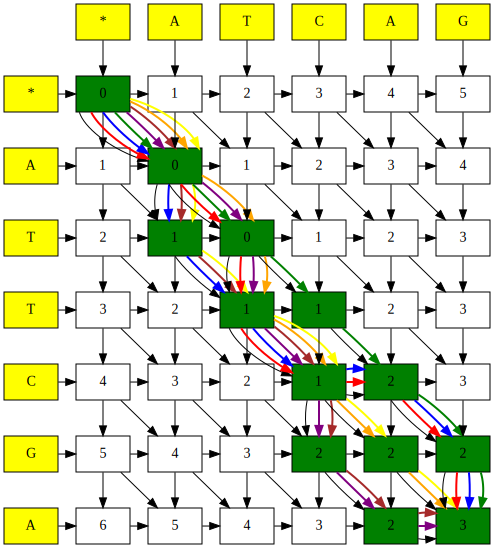

In [42]:
A2 = '*ATTCGA'
B2 = '*ATCAG'

D2 = [[0 for j in range(len(B2))] for i in range(len(A2))]

initialize_distance_matrix(A2, B2, D2)
compute_distance_matrix(A2, B2, D2)
print(f'Edit distance between {A2[1:]} and {B2[1:]} is {D2[-1][-1]}')

all_alignment_paths_D2 = list()
traceback_all_solutions(A2, B2, D2, all_alignment_paths_D2, len(A2)-1, len(B2)-1)
print(f'Found {len(all_alignment_paths_D2)} alignment paths')

G_dot2 = matrixpaths2dot(A2, B2, D2, all_alignment_paths_D2)
G_dot2


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 8</strong></h3>

Explain in your own words, intutively, why these two strings have so many optimal alignments, whereas `STOCKHOLM` and `TUKHOLMA` had only two optimal alignments, even if they have larger edit distance. 

<strong>Hint:</strong> For an extreme example, you might want to try the above computation also with `A2 = '*ABC'`, and `B2 = '*DEFGHIJK'`. 

---
#### Edit distance vs. number of optimal alignments

It makes sense, intuitively, that the difference is explained by the one very destictive match that the word STOCKHOLM and TUKHOLMA have: KHOLM with only one matching letter outside of it. The base sequences, on the other hand, have multiple matching letters across the sequences and therefore producing more options for the optimal path.

---

## 2.3 Edit distance computation as shortest path problem

The above `graphviz` diagram visualizing the distance matrix `D` as a graph should give you an intuition that computing the edit distance between two strings can be reduced to finding an "optimal" path in a graph. More precisely, since we want a *smallest* edit distance, then we will want a *shortest* path; recall that you already implemented an algorithm for this problem, in `computeShortestPath(G,s,t)` above. 

In fact, the nodes of the graph correspond exactly to the cells `[i][j]` of the matrix `D`. The target node `t` where the path is required to end is the bottom-right cell of `D`, and the source node is the top-left cell of `D`. Let us first construct this graph, and we will later add weights to its edges.

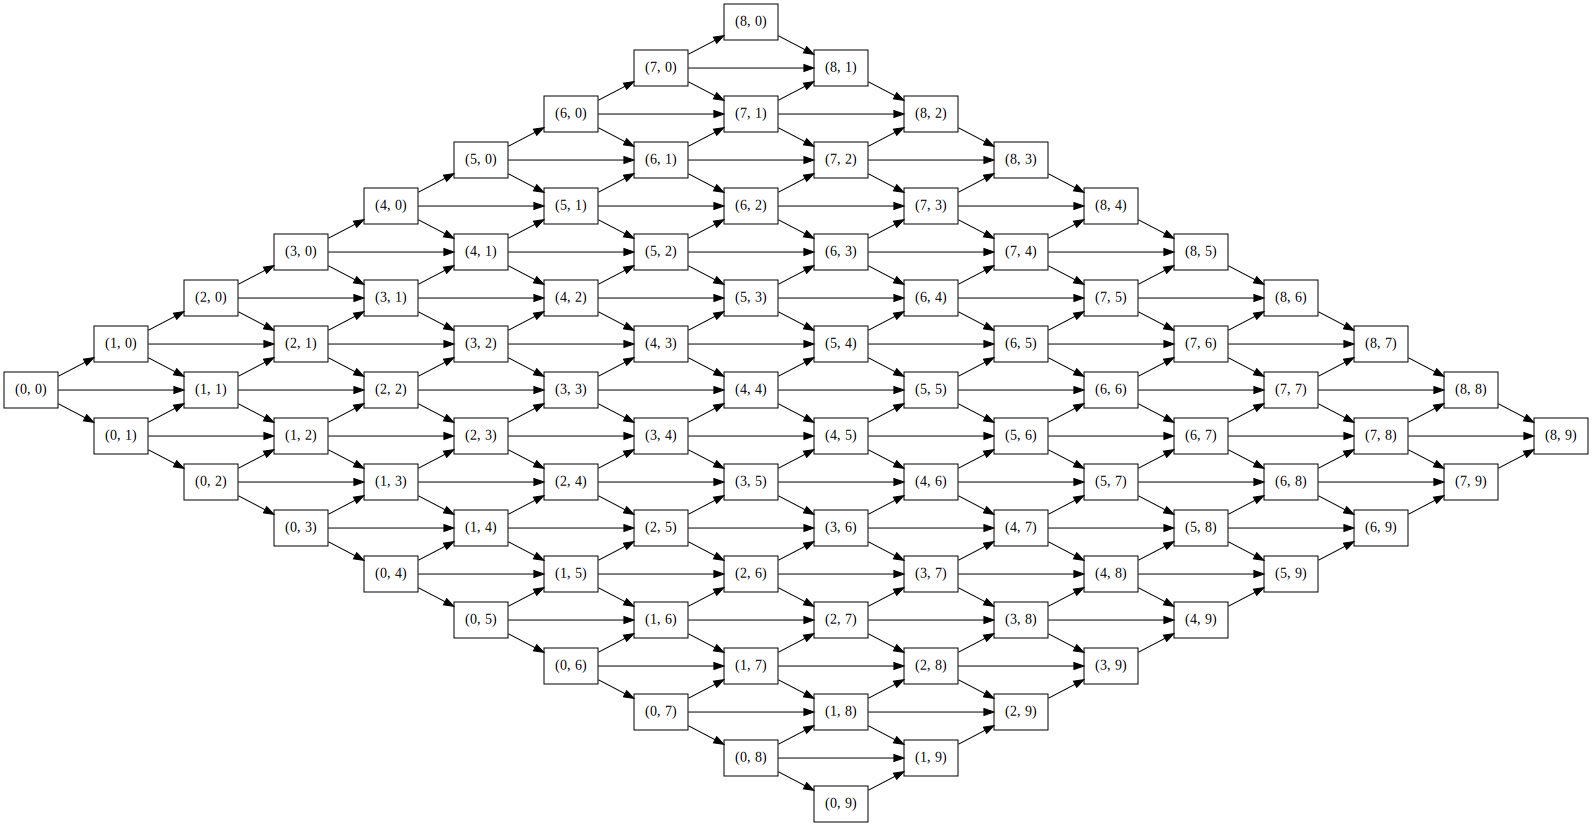

In [43]:
def reduceToGraph_incomplete(A,B):
    G = nx.DiGraph()
    for i in range(len(A)): # for every row of D
        for j in range(len(B)): # for every column of D
            G.add_node((i, j))
            if j > 0:
                G.add_edge((i, j-1), (i, j))
            if i > 0:
                G.add_edge((i-1, j), (i, j))
            if i > 0 and j > 0:
                G.add_edge((i-1, j-1), (i, j))
    return G
            
G = reduceToGraph_incomplete(A,B)
G_dot = graph2dot(G)
G_dot

To get the weights of the edges of the graph, recall the following diagram from the lecture:

<img width=500 src='data/ed-rule.png'>

This diagram implies the following edge weights:
- the edge from `(i, j-1)` to `(i, j)` gets weight $1$ (cost of insertion)
- the edge from `(i-1, j)` to `(i, j)` gets weight $1$ (cost of deletion)
- the edge from `(i-1, j-1)` to `(i, j)` gets weight $1$, if `A[i] != B[j]` (cost of substitution), or gets weight $0$ if `A[i] == B[j]` (no cost for matching)

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 9</strong></h3>

Modify the above function `reduceToGraph_incomplete(A,B)` so that it also adds weights to the graph. Fill in the missing code fragments below.

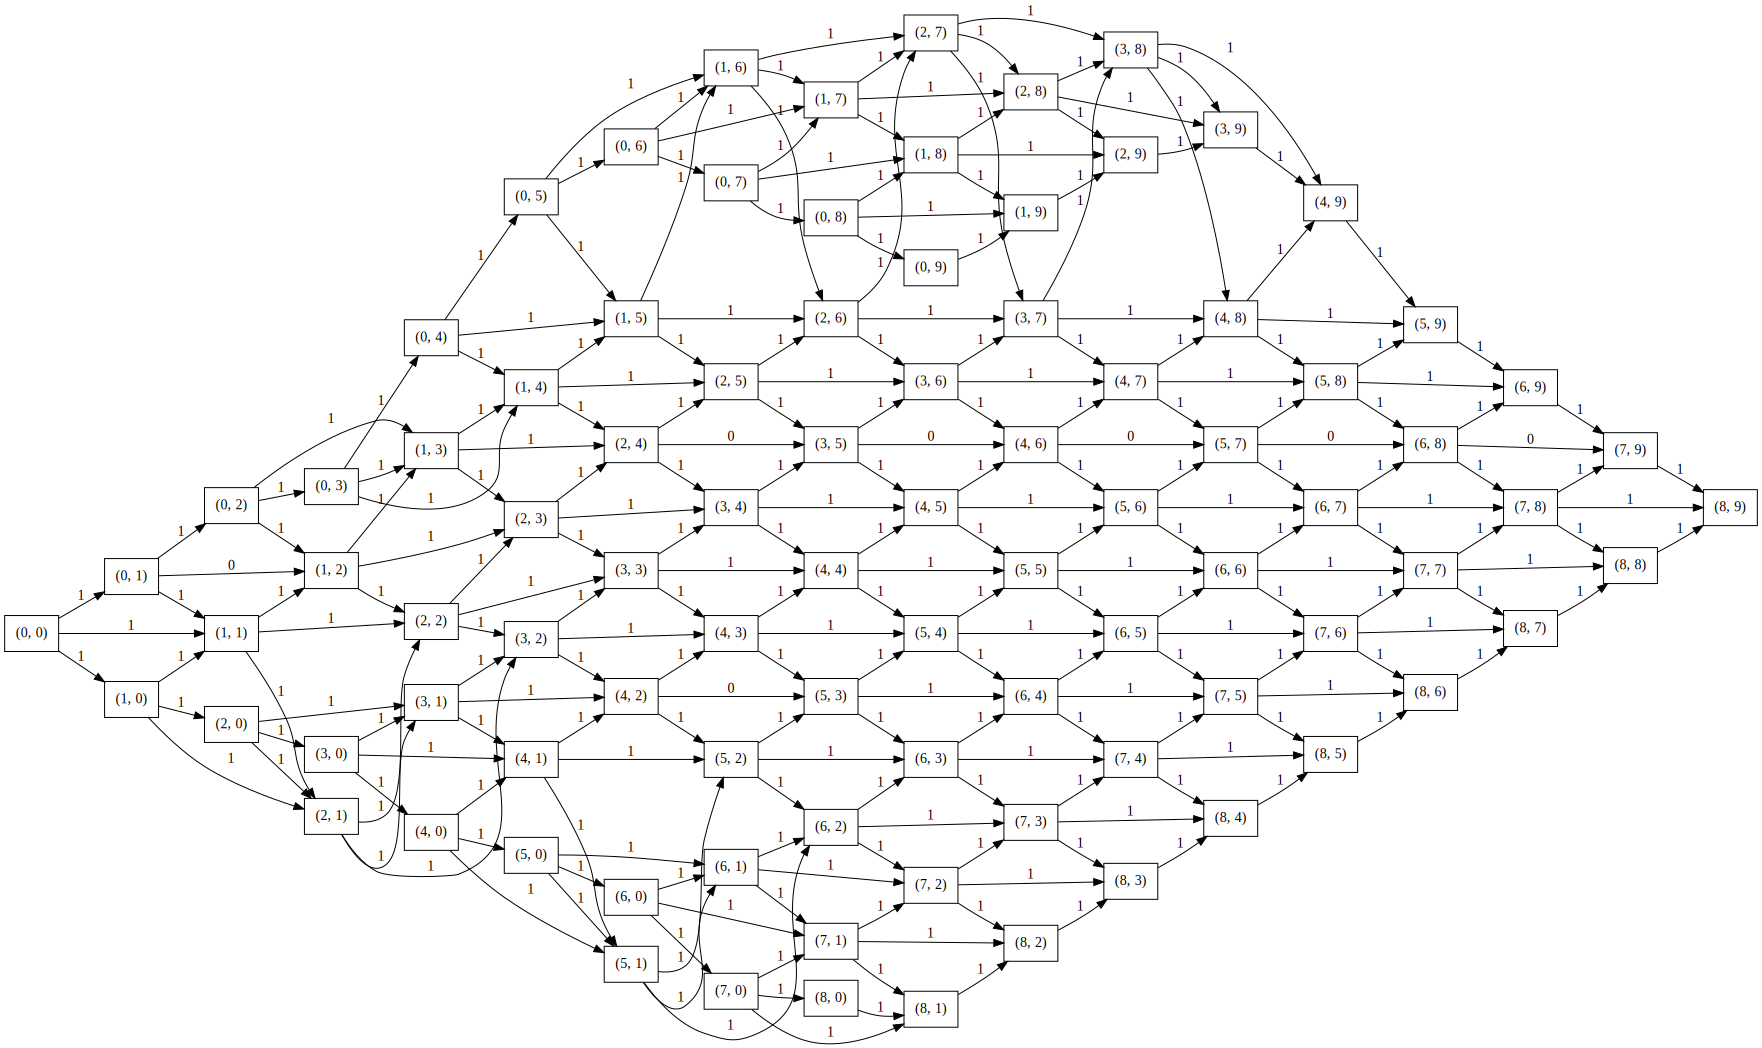

In [44]:
def reduceToGraph(A,B):
    G = nx.DiGraph()
    for i in range(len(A)): # for every row of D
        for j in range(len(B)): # for every column of D
            G.add_node((i, j))
            if j > 0:
                G.add_edge((i, j-1), (i, j), weight=1)
            if i > 0:
                G.add_edge((i-1, j), (i, j), weight=1)                
            if i > 0 and j > 0:
                if A[i] == B[j]:
                    w = 0
                else:
                    w = 1
                G.add_edge((i-1, j-1), (i, j), weight=w)
                
    return G

G = reduceToGraph(A,B)
G_dot = graph2dot(G, edgeLabels='weight')
G_dot

Having constructed (with `reduceToGraph`) a weighted graph corresponding to each index pair `(i, j)`, we solve the shortest path problem on this graph, using your function `computeShortestPath(G, s, t)` implemented above, where `s = (0, 0)` and `t = (len(A)-1, len(B)-1)`.

In [45]:
G = reduceToGraph(A,B)
editDistance, oneShortestPath = computeShortestPath(G, (0, 0), (len(A)-1, len(B)-1))
print(f'Edit distance of {A} and {B}: {editDistance}')
print(oneShortestPath)

Edit distance of *TUKHOLMA and *STOCKHOLM: 4
[(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)]


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 10</strong></h3>

- Does `oneShortestPath` equal one of the two optimal alginment paths in `D` that you obtained before?
- This is an example of another *reduction* from one problem (computing edit distance) to another (computing a shortest path). In fact, notice that in this reduction we did not compute the values of the cells of matrix `D`, we just used their indices `(i, j)` to construct the graph, and we assigned the weight of the edges by looking only at `A` and `B`. Explain in your own words why this reduction is correct.

---
#### Comparing the solutions

The previous given optimal alignments were:

- [(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)]
- [(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)]

The one gotten with the graph matches with the first one.

The graph reduction corresponds the problem, because here the weights of the edges correspond directly the way the values in the distance matrix are calculated. In fact, the matrix values equal the length of the shortest path to correponding node in the graph.

---

## 2.4 From alignment paths to sequence alignments

So far we got optimal alignment **paths** in the distance matrix, but not the actual optimal alignments of the two sequences. Let's address this now.

Recall again this diagram from the lecture:

<img width=500 src='data/ed-rule.png'>

This means that if we take a "vertical" edge then we must **delete** `A[i]` from `A`, if we take a "horizontal" edge then we must **insert** `B[j]` into `A`, and if we take a "diagonal" edge then we must **match** or **substitute** `A[i]` with `B[j]`. 

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 11</strong></h3>

Double-check that the code below produces the same two optimal alignments as in the lecture, and that they indeed correspond to the two optimal alignment paths. Explain in your own words how the code below works **and** why it implements what is described above.

In [48]:
def getAlignment(A, B, alignmentPath):
    alignmentMatrix = [['-' for index in range(len(alignmentPath))] for i in range(2)]
    
    alignmentMatrix[0][0] = A[0]
    alignmentMatrix[1][0] = B[0]
    
    for index in range(1, len(alignmentPath)):
        prev_i, prev_j = alignmentPath[index-1]
        i, j = alignmentPath[index]
        
        if i > prev_i:
            alignmentMatrix[0][index] = A[i]
        
        if j > prev_j:
            alignmentMatrix[1][index] = B[j]

    return alignmentMatrix
            
for alignment_path in all_alignment_paths_D:
    print(f'*** Alignment path {alignment_path} corresponds to sequence alignment:')
    alignmentMatrix = getAlignment(A, B, alignment_path)
    display(pandas.DataFrame(data=alignmentMatrix))

*** Alignment path [(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10
0,*,-,T,U,-,K,H,O,L,M,A
1,*,S,T,O,C,K,H,O,L,M,-


*** Alignment path [(0, 0), (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (8, 9)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10
0,*,-,T,-,U,K,H,O,L,M,A
1,*,S,T,O,C,K,H,O,L,M,-


---
#### getAlighment

First the alignment_matrix is initialized to have two rows of length of the aligned string of the '-' character. The first extra characters (*) are align in the beginning of each row of the matrix. Then the legth of the string is looped over and current character is compared to the previous. The dash (-) is changed in two cases:

1. If we have moved vertically, the dash on the upper row is replaced by the letter in A
2. If we have moved horizontally, the dash on the lower row is replaced by the letter in B

This is quite clever way to print the alignments, since vertical movement describes deletion and horizontal insertion. The same tame it handles the case of match and substitute, since if we move diagonally, both of the conditions (1 & 2) are satisfied and dashes replaced on both rows. 

---

# 3. Variant calling

In the variant calling problem, we are given a reference genome, and reads sequenced from a new genome (called *donor genome*). The task is to find which mutations are present in the donor with respect to the reference. 

In this section we implement a very basic read aligner, and try to infer the mutations from these alignments. The main goal of this section is to give you an idea of how the donor mutations could be inferred from the read alignments (also called *read pileup*), but also of the many practical issues present already in this small example.

Let's start with a variation of the function `initialize_distance_matrix(A, B, D)`.

In [49]:
def initialize_distance_matrix_new(A, B, D):
    for i in range(len(A)):
        D[i][0] = i
    for j in range(len(B)):
        D[0][j] = 0 # Before we had D[0][j] = j

Let's see how `initialize_distance_matrix_new(A, B, D)` can help us.

In [50]:
A3 = '*FROGILIS'
B3 = '*SUPERCALIFRAGILISTICEXPIALIDOCIOUS'
D3 = [ [ 0 for j in range(len(B3))] for i in range(len(A3)) ]

initialize_distance_matrix_new(A3, B3, D3) # We use the new initializing function
compute_distance_matrix(A3, B3, D3)
min_edit_distance_3 = min(D3[-1])
print(f'There exists an occurrence of {A3} inside {B3} of edit distance {min_edit_distance_3}')

There exists an occurrence of *FROGILIS inside *SUPERCALIFRAGILISTICEXPIALIDOCIOUS of edit distance 1


To understand why the above code returns such information with only a minor change to the initialization function, let's see what this occurence is.

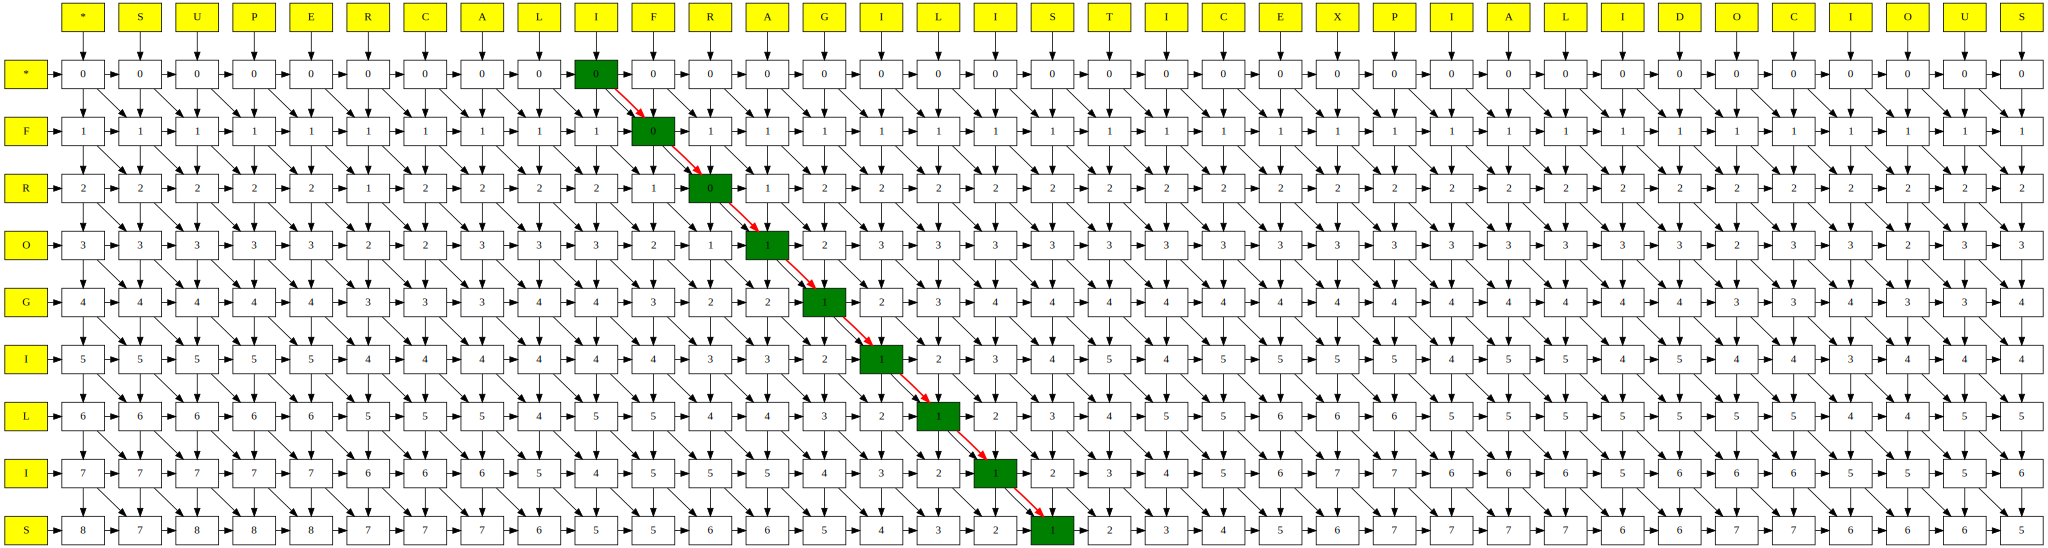

,0,1,2,3,4,5,6,7,8
0,*,F,R,O,G,I,L,I,S
1,*,F,R,A,G,I,L,I,S


In [51]:
alignment_paths_D3 = list()
best_j_3 = D3[-1].index(min_edit_distance_3)
traceback_all_solutions(A3, B3, D3, alignment_paths_D3, len(A3)-1, best_j_3)

G3_dot = matrixpaths2dot(A3, B3, D3, alignment_paths_D3)
display(G3_dot)

alignmentMatrix_D3 = getAlignment(A3, B3, alignment_paths_D3[0])

display(pandas.DataFrame(data=alignmentMatrix_D3))

<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 12</strong></h3>

Explain how the above code works and how it manages to find the occurrence of `A3` of minimum edit distance inside `B3`.

**Hint:** Remember that we use the new initialization function `initialize_distance_matrix_new`.

---
#### Occurence finding with initialize_distance_matrix_new

The change made to the matrix intitalizing function was to leave the upper row as zero for each column. This small change allows the matching to start anywhere along the sequence B3, not calculating the missmatches in the beginning into the edit distance. Determining the edit distance as the minimum of the last row, on the other hand, ignores the missmatches after the sequence A3 has reached its end.

---

Let's now assume that we have a reference genome and some donor reads. Run the code below, which aligns each read (in the same manner as above), but in addition prints **all** optimal alignments of each read inside the reference genome.

In [52]:
pandas.options.display.max_columns = None

referenceGenome = '*ACAAGAATACGACGATAG'
reads = ['*ACATGAA', '*CATGAAT', '*ATGAATA', '*TGAATAC', '*GAATACA', '*AATACAC', '*ATACACG', '*TACACGA', '*ACACGAC', '*CACGACT', '*ACGACTA', '*CGACTAG']

for read in reads:
    print(f'\n\n--- Aligning {read}')
    A4 = read
    B4 = referenceGenome
    D4 = [ [ 0 for j in range(len(B4))] for i in range(len(A4)) ]
    initialize_distance_matrix_new(A4, B4, D4)
    compute_distance_matrix(A4, B4, D4)
    all_alignment_paths_D4 = list()

    min_edit_distance = min(D4[-1])

    for j in range(len(B4)):
        if D4[-1][j] == min_edit_distance:
            alignment_paths_from_j = list()
            traceback_all_solutions(A4, B4, D4, alignment_paths_from_j, len(A4)-1, j)
            all_alignment_paths_D4 += alignment_paths_from_j

    print(f'Read {read} has {len(all_alignment_paths_D4)} optimal alignment(s) of edit distance {min_edit_distance}')
    for alignment_path in all_alignment_paths_D4:
        print(f'*** Alignment path {alignment_path} corresponds to sequence alignment:')
        alignmentMatrix = getAlignment(A4, B4, alignment_path)
        
        # Remove * character from beggining
        alignmentMatrix = [alignmentMatrix[0][1:], alignmentMatrix[1][1:]]
    
        # Add padding to show whole B4 sequence
        for i in reversed(range(1, alignment_path[0][1]+1)):
            alignmentMatrix[0] = [' '] + alignmentMatrix[0]
            alignmentMatrix[1] = [B4[i]] + alignmentMatrix[1]
        for i in range(1, len(B4)-alignment_path[-1][1]):
            alignmentMatrix[0] = alignmentMatrix[0] + [' ']
            alignmentMatrix[1] = alignmentMatrix[1] + [B4[alignment_path[-1][1] + i]]
        
        display(pandas.DataFrame(data=alignmentMatrix))



--- Aligning *ACATGAA
Read *ACATGAA has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,A,C,A,T,G,A,A,,,,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *CATGAAT
Read *CATGAAT has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,C,A,T,G,A,A,T,,,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *ATGAATA
Read *ATGAATA has 2 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 3), (1, 4), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,A,T,G,A,A,T,A,,,,,,,,,
1,A,C,A,A,-,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,A,T,G,A,A,T,A,,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *TGAATAC
Read *TGAATAC has 2 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 4), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,T,G,A,A,T,A,C,,,,,,,,
1,A,C,A,A,-,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 3), (1, 4), (2, 5), (3, 6), (4, 7), (5, 8), (6, 9), (7, 10)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,T,G,A,A,T,A,C,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *GAATACA
Read *GAATACA has 3 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 10)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,G,A,A,T,A,C,A,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,-,G,A,C,G,A,T,A,G


*** Alignment path [(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,G,A,A,T,A,C,A,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (6, 11), (7, 12)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,G,A,A,T,A,C,-,A,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *AATACAC
Read *AATACAC has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 5), (1, 6), (2, 7), (3, 8), (4, 9), (5, 10), (5, 11), (6, 12), (7, 13)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,A,A,T,A,C,-,A,C,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *ATACACG
Read *ATACACG has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (4, 11), (5, 12), (6, 13), (7, 14)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,A,T,A,C,-,A,C,G,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *TACACGA
Read *TACACGA has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 7), (1, 8), (2, 9), (3, 10), (3, 11), (4, 12), (5, 13), (6, 14), (7, 15)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,T,A,C,-,A,C,G,A,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *ACACGAC
Read *ACACGAC has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,A,C,A,C,G,A,C,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G




--- Aligning *CACGACT
Read *CACGACT has 8 optimal alignment(s) of edit distance 2
*** Alignment path [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,C,A,C,G,A,C,T,,,,,,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 8), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13), (7, 13)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,C,A,C,G,A,C,T,,,,,
1,A,C,A,A,G,A,A,T,-,A,C,G,A,C,-,G,A,T,A,G


*** Alignment path [(0, 7), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13), (7, 13)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,C,A,C,G,A,C,T,,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,-,G,A,T,A,G


*** Alignment path [(0, 8), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13), (7, 14)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,C,A,C,G,A,C,T,,,,
1,A,C,A,A,G,A,A,T,-,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 7), (1, 8), (2, 9), (3, 10), (4, 11), (5, 12), (6, 13), (7, 14)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,C,A,C,G,A,C,T,,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 11), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 15), (7, 16)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,,,,C,A,C,G,A,C,T,,
1,A,C,A,A,G,A,A,T,A,C,G,-,A,C,G,A,-,T,A,G


*** Alignment path [(0, 9), (1, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 15), (7, 16)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,C,-,A,C,G,A,C,T,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,-,T,A,G


*** Alignment path [(0, 10), (1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 15), (7, 16)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,,C,A,C,G,A,C,T,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,-,T,A,G




--- Aligning *ACGACTA
Read *ACGACTA has 2 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 8), (1, 9), (2, 10), (3, 11), (4, 12), (5, 13), (6, 14), (7, 15)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,A,C,G,A,C,T,A,,,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,T,A,G


*** Alignment path [(0, 11), (1, 12), (2, 13), (3, 14), (4, 15), (5, 15), (6, 16), (7, 17)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,,,A,C,G,A,C,T,A,
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,-,T,A,G




--- Aligning *CGACTAG
Read *CGACTAG has 1 optimal alignment(s) of edit distance 1
*** Alignment path [(0, 12), (1, 13), (2, 14), (3, 15), (4, 15), (5, 16), (6, 17), (7, 18)] corresponds to sequence alignment:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,,,,C,G,A,C,T,A,G
1,A,C,A,A,G,A,A,T,A,C,G,A,C,G,A,-,T,A,G


<h3 style='background:yellow;padding:10px;color:black'><strong>TASK 13</strong></h3>

From the above results, try your best to infer what mutations there are in the donor with respect to `referenceGenome`. What makes this question difficult?

---
#### Mutations

(If I was smart I would add a part to the code that would calculate this for me, but since I'm not...) Gauging the results, there can be found a couple of mutatuons that seem to repeat across the samples:

- Sbstitution in place 3: T -> A (occurs in almos every match covering the area)
- Deletion in place 10: G -> - (occurs many times but also many times not)
- Insertion in place 15: - -> C (occurs a couple of times)

Even the list above is uncertain but any further guesses could be even more easily explained by sequencing errors and other noise. Based on these samples, some of the other mutations are equally likely but cannot exist at the same time.


---